<a href="https://colab.research.google.com/github/rufimelo99/UltimatumGame/blob/main/UltimatumGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classes

##Player Class

In [2]:
import random
import numpy as np
import numpy.random as rnd
import math
from enum import Enum
bargainValues = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85, 0.9,0.95,1.0]
mapValuesIndex = {0: 0, 0.05: 1, 0.1: 2, 0.15: 3, 0.2:4, 0.25: 5, 0.3: 6, 0.35: 7, 0.4: 8, 0.45: 9, 0.5: 10, 0.55: 11, 0.6: 12, 0.65: 13, 0.7: 14, 0.75: 15, 0.8: 16, 0.85: 17, 0.9: 18, 0.95: 19, 1: 20}
mapIndexValues = {0: 0, 1: 0.05, 2: 0.1, 3: 0.15, 4:0.2, 5: 0.25, 6: 0.3, 7: 0.35, 8: 0.4, 9: 0.45, 10: 5, 11: 5.5, 12: 6, 13: 6.5, 14: 7, 15: 7.5, 16: 8, 17: 8.5, 18: 9, 19: 9.5, 20: 1}

class PlayerRole(Enum):
    EMPATHETIC = 1
    PRAGMATIC = 2
    INDEPENDENT = 3

class Player:
    def __init__(self, id, PlayerRole) -> None:
        self.id=id
        self.neighbours = []
        self.ComulativePayoff = 0

        self.pValue=0
        self.qValue=0
        self.PlayerRole=PlayerRole

        
        self.AvgPayoff=0
        self.gamesPlayed=0

    def attributeStrategy(self):
      if self.PlayerRole == PlayerRole.EMPATHETIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = self.pValue
      elif self.PlayerRole == PlayerRole.PRAGMATIC :
        self.pValue = random.choice(bargainValues)
        self.qValue = 1-self.pValue
      elif self.PlayerRole == PlayerRole.INDEPENDENT :
        self.pValue = random.choice(bargainValues)
        self.qValue = random.choice(bargainValues)



    def makeOffer(self):
        #returns index of bargain proposal 
        #offer from Proposer
        return mapValuesIndex[self.pValue]

    def bargainDecision(self, bargainValueIndex):
        if mapIndexValues[bargainValueIndex]>=self.qValue:
          return 1
        else:
          return 0 


## Ultimatum Game Class

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

stopsForGraphs = [1,100,500,1000,10000,20000,50000,100000,1000000]

class ultimatumGame:
  
    def __init__(self, Nplayers, PlayerRole, ScaleFree=False) -> None:
        
        if ScaleFree:
          #Scale-Free
          #self.graph = nx.complete_graph(Nplayers)
          #ver aqui o argumento n
          self.graph = nx.barabasi_albert_graph(Nplayers, 2)
        else:
          #Erdos-Renyi
          self.graph = nx.erdos_renyi_graph(Nplayers, 0.4)

        self.Players = {}
        
        #uniforms distributions i gueess TODO
        pValuesForAll = random.choices (bargainValues,k=Nplayers)
        #if needed
        qValuesForAll = random.choices (bargainValues,k=Nplayers)

        #create all players
        for i in range(Nplayers):
            player = Player(i, PlayerRole)
            player.neighbours = list(self.graph.adj[i])

            if PlayerRole == PlayerRole.EMPATHETIC :
              player.pValue = pValuesForAll[i]
              player.qValue = player.pValue
            elif PlayerRole == PlayerRole.PRAGMATIC :
              player.pValue = pValuesForAll[i]
              player.qValue = 1-player.pValue
            elif PlayerRole == PlayerRole.INDEPENDENT :
              player.pValue = pValuesForAll[i]
              player.qValue = qValuesForAll[i]

            self.Players[i]=player
        print("Network created")  

    def printGraph(self):
        #nx.draw_shell(self.graph, with_labels = True)
        #nx.draw(self.graph, with_labels = True)
        
        fig = plt.figure(figsize=(40, 40)) 
        nx.draw(self.graph, node_size=150, with_labels = True) 
        plt.axis('equal') 
        plt.show() 
        plt.show()

    def runEpisode(self, actualIteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs,NaturalSelection=True,SocialPenalty=True):
      for playerId in range(len(self.Players)):
        if NaturalSelection:
          #natural selection -> see if there is a better policy in a random j neighbour and define a probability to use j's strategy 
          player = self.Players[playerId]
          if player.neighbours!=[]:
            #see if my random neighbour has a better startegy
            randomNeighbourIndex = rnd.choice(len(player.neighbours))
            randomNeighbour = self.Players[player.neighbours[randomNeighbourIndex]]
            if randomNeighbour.ComulativePayoff > player.ComulativePayoff and actualIteration != 1:
              #see here
              #usar max
              higherDegree=np.max([len(player.neighbours),len(randomNeighbour.neighbours)])

              probUsingNeighbourStategy = round(((randomNeighbour.ComulativePayoff-player.ComulativePayoff)/ (2*higherDegree)),3)
              prob = probUsingNeighbourStategy
              usingExternalPolicy = rnd.choice([0, 1], p = [1-prob, prob])
              if usingExternalPolicy:
                player.qValue = randomNeighbour.qValue
                player.pValue = randomNeighbour.pValue

        #episode itself   -> play the game  
        for neighbourId in self.Players[playerId].neighbours:
          player = self.Players[playerId]
          neighbour = self.Players[neighbourId]
          
          playerBargainIndex=player.makeOffer()
          rewardAcceptedOrNot = neighbour.bargainDecision(playerBargainIndex)
          
          playerReward = bargainValues[-(playerBargainIndex+1)]
          neighbourReward = bargainValues[playerBargainIndex]
          
          #add payoffs to player  
          player.ComulativePayoff+=rewardAcceptedOrNot*playerReward
          neighbour.ComulativePayoff+=rewardAcceptedOrNot*neighbourReward
          
          player.gamesPlayed += 1
          neighbour.gamesPlayed += 1

          #save info for graphics
          if actualIteration in stopsForGraphs:
            offersDicInitial[bargainValues[playerBargainIndex]]+=1
            thresholdDicInitial[bargainValues[-(playerBargainIndex+1)]]+=1
      

      #save data for graphs
      if actualIteration in stopsForGraphs:
        offerDic[actualIteration]=offersDicInitial.copy()
        offersDicInitial.update({}.fromkeys(offersDicInitial,0))
        thresholdDic[actualIteration]=thresholdDicInitial.copy()
        thresholdDicInitial.update({}.fromkeys(thresholdDicInitial,0))
      

      #get the comulative payoffs after a round-robin round
      lowerPayoff = len(self.Players) #just a awful large number
      lowerPayoffId = 0
      for playerId in range(len(self.Players)):
        player = self.Players[playerId]
        if player.neighbours!=[]:
          
          player.AvgPayoff = player.ComulativePayoff/player.gamesPlayed

          #updating lowerPayoff if necessary
          if player.ComulativePayoff<lowerPayoff:
            lowerPayoff=player.ComulativePayoff
            lowerPayoffId=player.id

          #reseting payoffs of that round
          player.ComulativePayoff = 0
          player.gamesPlayed = 0 
        
      #Social penalty
      #see neigbours policy->comunidaades
      if SocialPenalty:
        playerToBeRemoved = self.Players[lowerPayoffId]
        #handle its neighbours
        for i in playerToBeRemoved.neighbours:
          #update its q and p values     
          self.Players[i].attributeStrategy()

        #update q and p Values
        playerToBeRemoved.attributeStrategy()


      return offersDicInitial,offerDic,thresholdDicInitial,thresholdDic
          

# Execution

## Natural Selection

### Empathetic Erdos-Renyi

Network created
iteration: 0
iteration: 20
iteration: 40
iteration: 60
iteration: 80
iteration: 100
iteration: 120
iteration: 140
iteration: 160
iteration: 180
iteration: 200
iteration: 220
iteration: 240
iteration: 260
iteration: 280
iteration: 300
iteration: 320
iteration: 340
iteration: 360
iteration: 380
iteration: 400
iteration: 420
iteration: 440
iteration: 460
iteration: 480
iteration: 500
iteration: 520
iteration: 540
iteration: 560
iteration: 580
iteration: 600
iteration: 620
iteration: 640
iteration: 660
iteration: 680
iteration: 700
iteration: 720
iteration: 740
iteration: 760
iteration: 780
iteration: 800
iteration: 820
iteration: 840
iteration: 860
iteration: 880
iteration: 900
iteration: 920
iteration: 940
iteration: 960
iteration: 980
iteration: 1000


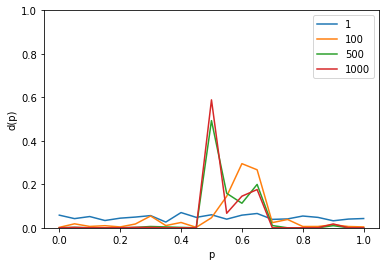

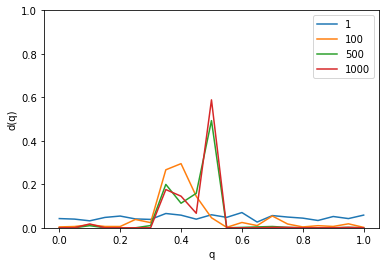

In [27]:
NPLAYERS =  500
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)


plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Empathetic Scale Free

Network created
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
iteration: 1000


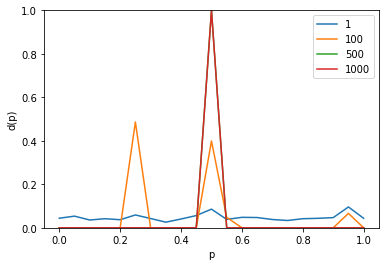

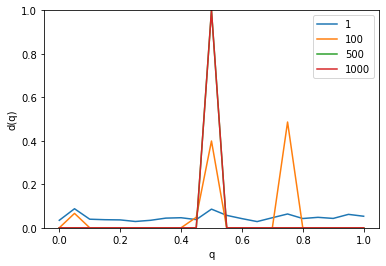

In [40]:
NPLAYERS =  500
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Pragmatic Erdos-Renyi

Network created
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
iteration: 1000


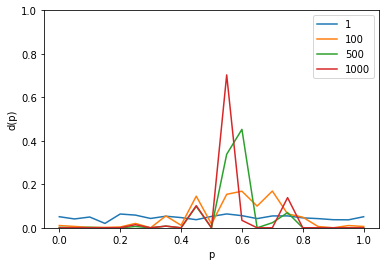

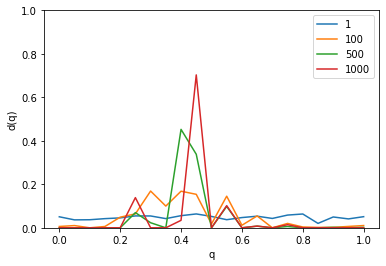

In [28]:
NPLAYERS =  500
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)


plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Pragmatic Scale Free

Network created
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
iteration: 1000


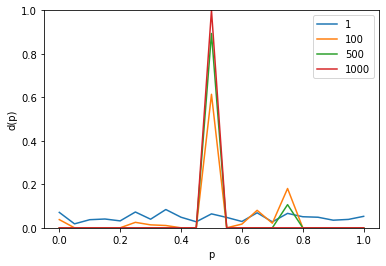

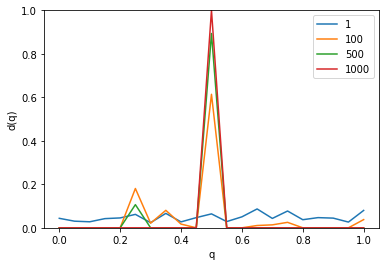

In [29]:
NPLAYERS =  500
NITERATIONS = 1001
game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)




plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Independent Erdos-Renyi

Network created
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
iteration: 1000


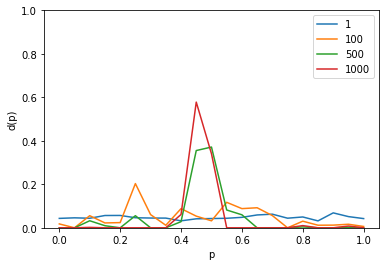

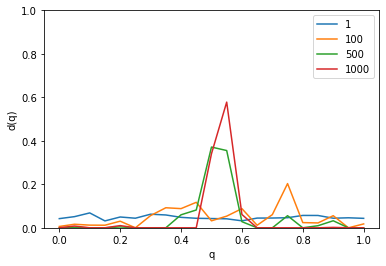

In [31]:
NPLAYERS =  500
NITERATIONS = 1001
game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)


plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




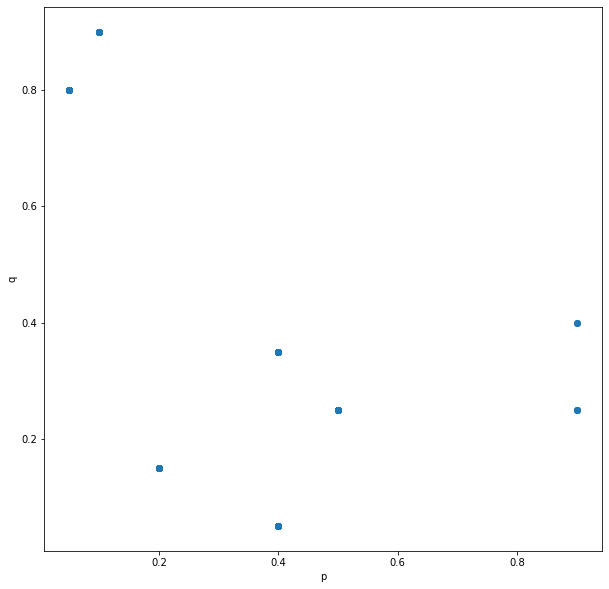

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

### Independent Scale Free

Network created
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
iteration: 1000


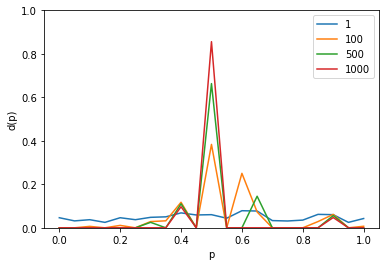

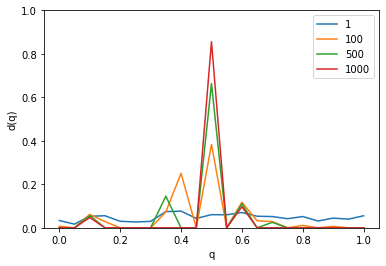

In [32]:
NPLAYERS =  500
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=False)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




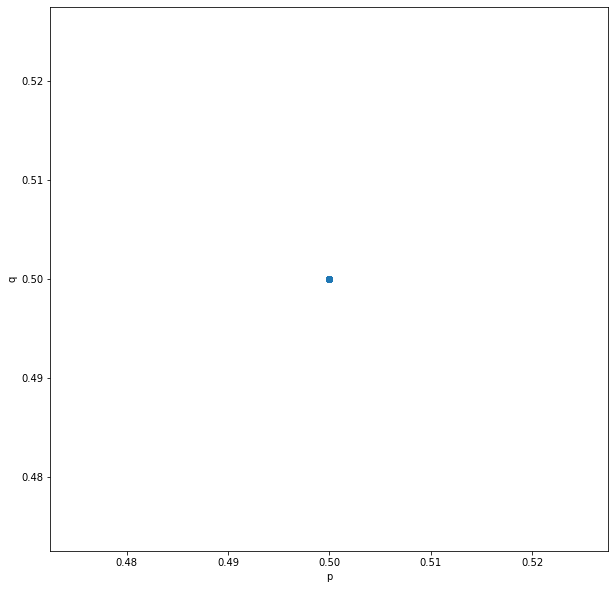

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

## Social Penalty

### Empathetic Erdos-Renyi

Network created
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
iteration: 100000
iteration: 120000
iteration: 140000
iteration: 160000
iteration: 180000
iteration: 200000
iteration: 220000
iteration: 240000
iteration: 260000
iteration: 280000
iteration: 300000
iteration: 320000
iteration: 340000
iteration: 360000
iteration: 380000
iteration: 400000
iteration: 420000
iteration: 440000
iteration: 460000
iteration: 480000
iteration: 500000
iteration: 520000
iteration: 540000
iteration: 560000
iteration: 580000
iteration: 600000
iteration: 620000
iteration: 640000
iteration: 660000
iteration: 680000
iteration: 700000
iteration: 720000
iteration: 740000
iteration: 760000
iteration: 780000
iteration: 800000
iteration: 820000
iteration: 840000
iteration: 860000
iteration: 880000
iteration: 900000
iteration: 920000
iteration: 940000
iteration: 960000
iteration: 980000
iteration: 1000000


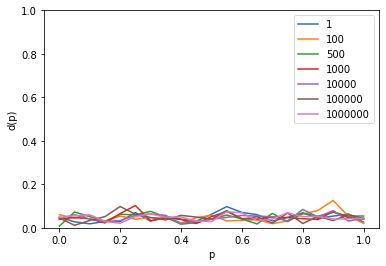

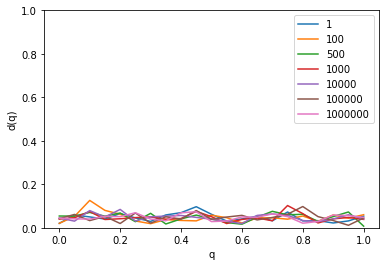

In [6]:
NPLAYERS =  100
NITERATIONS = 1000001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(offerDic[1000000].values()))/sum(np.array(list(offerDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000000].values()))/sum(np.array(list(thresholdDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




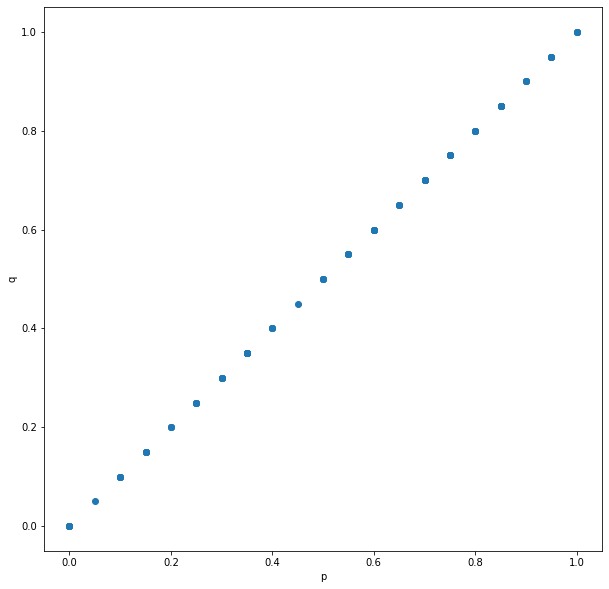

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

### Empathetic Scale Free

Network created
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
iteration: 100000
iteration: 120000
iteration: 140000
iteration: 160000
iteration: 180000
iteration: 200000
iteration: 220000
iteration: 240000
iteration: 260000
iteration: 280000
iteration: 300000
iteration: 320000
iteration: 340000
iteration: 360000
iteration: 380000
iteration: 400000
iteration: 420000
iteration: 440000
iteration: 460000
iteration: 480000
iteration: 500000
iteration: 520000
iteration: 540000
iteration: 560000
iteration: 580000
iteration: 600000
iteration: 620000
iteration: 640000
iteration: 660000
iteration: 680000
iteration: 700000
iteration: 720000
iteration: 740000
iteration: 760000
iteration: 780000
iteration: 800000
iteration: 820000
iteration: 840000
iteration: 860000
iteration: 880000
iteration: 900000
iteration: 920000
iteration: 940000
iteration: 960000
iteration: 980000
iteration: 1000000


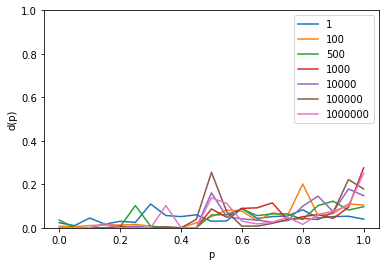

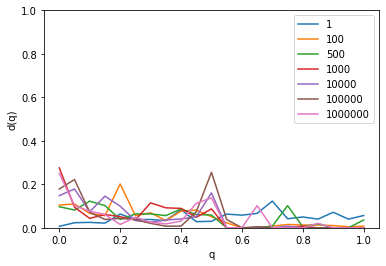

In [9]:
NPLAYERS =  100
NITERATIONS = 1000001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(offerDic[1000000].values()))/sum(np.array(list(offerDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000000].values()))/sum(np.array(list(thresholdDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()






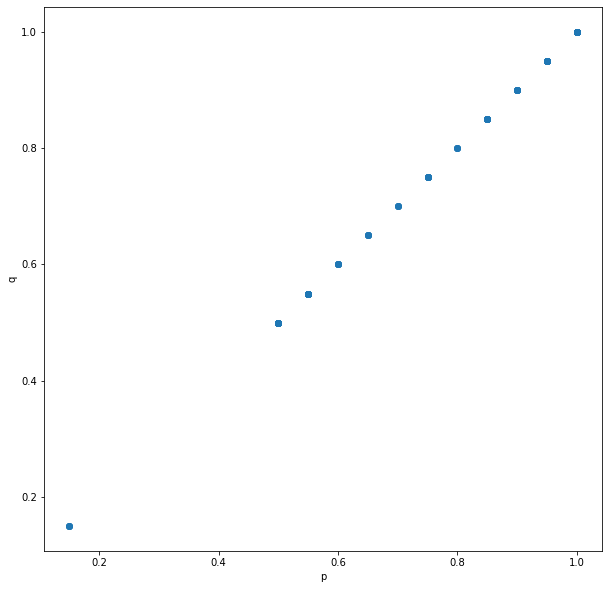

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

Network created
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
iteration: 100000
iteration: 120000
iteration: 140000
iteration: 160000
iteration: 180000
iteration: 200000
iteration: 220000
iteration: 240000
iteration: 260000
iteration: 280000
iteration: 300000
iteration: 320000
iteration: 340000
iteration: 360000
iteration: 380000
iteration: 400000
iteration: 420000
iteration: 440000
iteration: 460000
iteration: 480000
iteration: 500000
iteration: 520000
iteration: 540000
iteration: 560000
iteration: 580000
iteration: 600000
iteration: 620000
iteration: 640000
iteration: 660000
iteration: 680000
iteration: 700000
iteration: 720000
iteration: 740000
iteration: 760000
iteration: 780000
iteration: 800000
iteration: 820000
iteration: 840000
iteration: 860000
iteration: 880000
iteration: 900000
iteration: 920000
iteration: 940000
iteration: 960000
iteration: 980000
iteration: 1000000


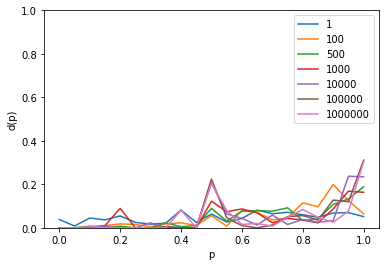

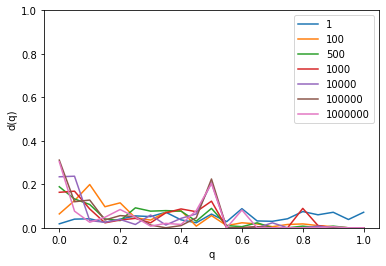

In [12]:
NPLAYERS =  100
NITERATIONS = 1000001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(offerDic[1000000].values()))/sum(np.array(list(offerDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000000].values()))/sum(np.array(list(thresholdDic[1000000].values()))) , label = "1000000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()






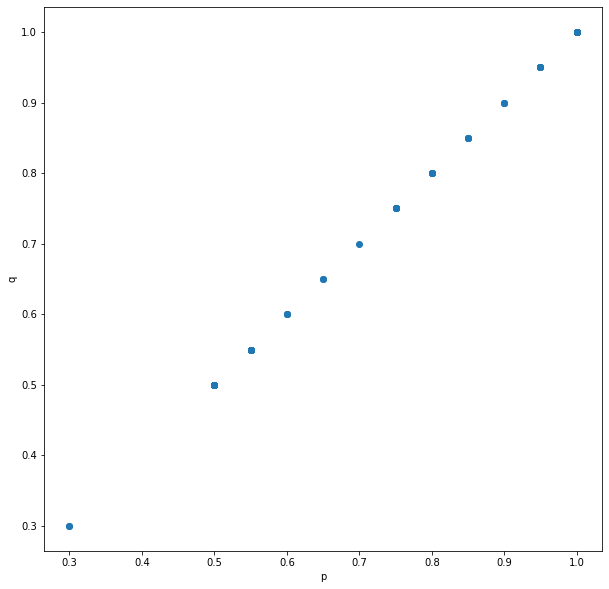

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

### Pragmatic Erdos-Renyi

Network created
iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000
iteration: 10000
iteration: 12000
iteration: 14000
iteration: 16000
iteration: 18000
iteration: 20000
iteration: 22000
iteration: 24000
iteration: 26000
iteration: 28000
iteration: 30000
iteration: 32000
iteration: 34000
iteration: 36000
iteration: 38000
iteration: 40000
iteration: 42000
iteration: 44000
iteration: 46000
iteration: 48000
iteration: 50000
iteration: 52000
iteration: 54000
iteration: 56000
iteration: 58000
iteration: 60000
iteration: 62000
iteration: 64000
iteration: 66000
iteration: 68000
iteration: 70000
iteration: 72000
iteration: 74000
iteration: 76000
iteration: 78000
iteration: 80000
iteration: 82000
iteration: 84000
iteration: 86000
iteration: 88000
iteration: 90000
iteration: 92000
iteration: 94000
iteration: 96000
iteration: 98000
iteration: 100000


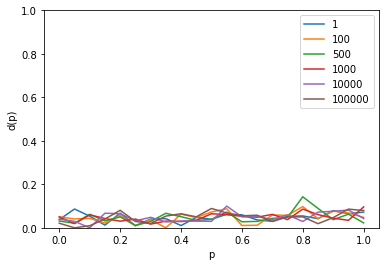

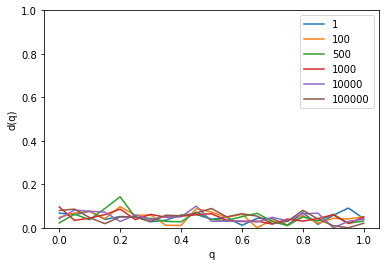

In [51]:
NPLAYERS =  100
NITERATIONS = 100001

game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()







### Pragmatic Scale Free

Network created
iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000
iteration: 10000
iteration: 12000
iteration: 14000
iteration: 16000
iteration: 18000
iteration: 20000
iteration: 22000
iteration: 24000
iteration: 26000
iteration: 28000
iteration: 30000
iteration: 32000
iteration: 34000
iteration: 36000
iteration: 38000
iteration: 40000
iteration: 42000
iteration: 44000
iteration: 46000
iteration: 48000
iteration: 50000
iteration: 52000
iteration: 54000
iteration: 56000
iteration: 58000
iteration: 60000
iteration: 62000
iteration: 64000
iteration: 66000
iteration: 68000
iteration: 70000
iteration: 72000
iteration: 74000
iteration: 76000
iteration: 78000
iteration: 80000
iteration: 82000
iteration: 84000
iteration: 86000
iteration: 88000
iteration: 90000
iteration: 92000
iteration: 94000
iteration: 96000
iteration: 98000
iteration: 100000


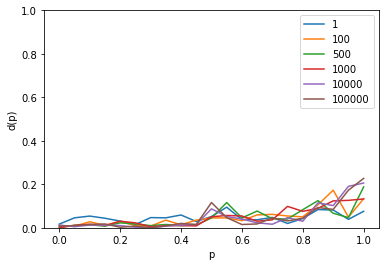

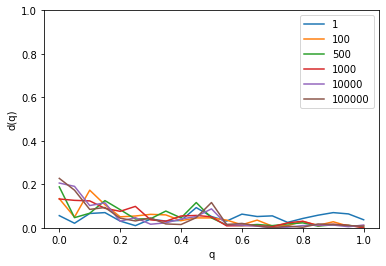

In [5]:
NPLAYERS =  200
NITERATIONS = 100001
game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()





### Independent Erdos-Renyi

Network created
iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000
iteration: 10000
iteration: 12000
iteration: 14000
iteration: 16000
iteration: 18000
iteration: 20000
iteration: 22000
iteration: 24000
iteration: 26000
iteration: 28000
iteration: 30000
iteration: 32000
iteration: 34000
iteration: 36000
iteration: 38000
iteration: 40000
iteration: 42000
iteration: 44000
iteration: 46000
iteration: 48000
iteration: 50000
iteration: 52000
iteration: 54000
iteration: 56000
iteration: 58000
iteration: 60000
iteration: 62000
iteration: 64000
iteration: 66000
iteration: 68000
iteration: 70000
iteration: 72000
iteration: 74000
iteration: 76000
iteration: 78000
iteration: 80000
iteration: 82000
iteration: 84000
iteration: 86000
iteration: 88000
iteration: 90000
iteration: 92000
iteration: 94000
iteration: 96000
iteration: 98000
iteration: 100000


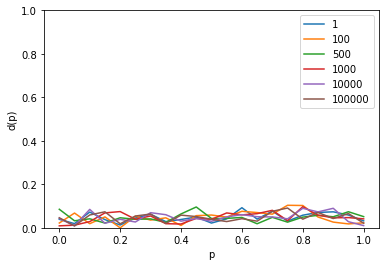

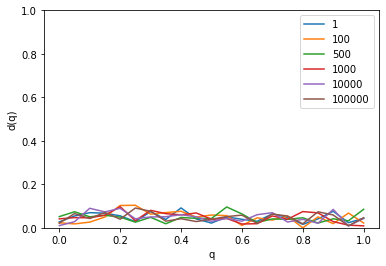

In [53]:
NPLAYERS =  100
NITERATIONS = 100001
game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()








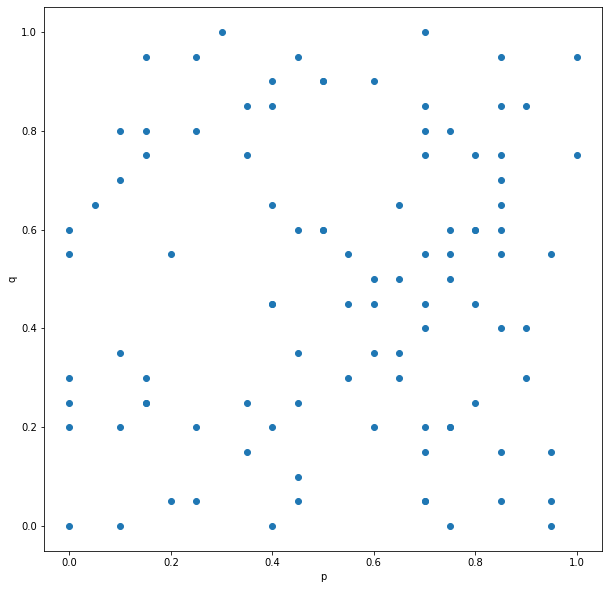

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

### Independent Scale Free

Network created
iteration: 0
iteration: 2000
iteration: 4000
iteration: 6000
iteration: 8000
iteration: 10000
iteration: 12000
iteration: 14000
iteration: 16000
iteration: 18000
iteration: 20000
iteration: 22000
iteration: 24000
iteration: 26000
iteration: 28000
iteration: 30000
iteration: 32000
iteration: 34000
iteration: 36000
iteration: 38000
iteration: 40000
iteration: 42000
iteration: 44000
iteration: 46000
iteration: 48000
iteration: 50000
iteration: 52000
iteration: 54000
iteration: 56000
iteration: 58000
iteration: 60000
iteration: 62000
iteration: 64000
iteration: 66000
iteration: 68000
iteration: 70000
iteration: 72000
iteration: 74000
iteration: 76000
iteration: 78000
iteration: 80000
iteration: 82000
iteration: 84000
iteration: 86000
iteration: 88000
iteration: 90000
iteration: 92000
iteration: 94000
iteration: 96000
iteration: 98000
iteration: 100000


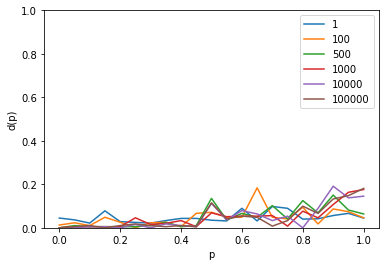

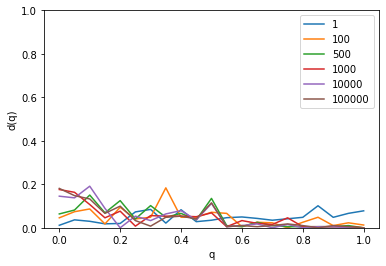

In [4]:
NPLAYERS =  100
NITERATIONS = 100001

game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=False, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[500].values()))/sum(np.array(list(offerDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(offerDic[100000].values()))/sum(np.array(list(offerDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[500].values()))/sum(np.array(list(thresholdDic[500].values()))) , label = "500" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )
plt.plot(bargainValues, np.array(list(thresholdDic[100000].values()))/sum(np.array(list(thresholdDic[100000].values()))) , label = "100000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()








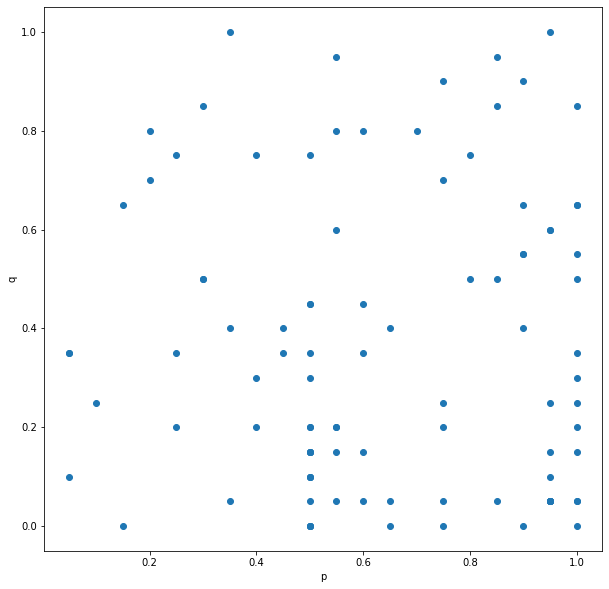

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

## Natural Selection and Social Penalty


### Empathetic Erdos-Renyi

In [ ]:
NPLAYERS =  1000
NITERATIONS = 10001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//50)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




Network created
iteration: 0
iteration: 200
iteration: 400
iteration: 600
iteration: 800
iteration: 1000
iteration: 1200
iteration: 1400
iteration: 1600
iteration: 1800
iteration: 2000
iteration: 2200
iteration: 2400
iteration: 2600
iteration: 2800
iteration: 3000
iteration: 3200
iteration: 3400
iteration: 3600
iteration: 3800
iteration: 4000
iteration: 4200
iteration: 4400
iteration: 4600
iteration: 4800
iteration: 5000
iteration: 5200
iteration: 5400
iteration: 5600
iteration: 5800
iteration: 6000
iteration: 6200
iteration: 6400
iteration: 6600
iteration: 6800
iteration: 7000
iteration: 7200
iteration: 7400
iteration: 7600
iteration: 7800
iteration: 8000
iteration: 8200
iteration: 8400
iteration: 8600
iteration: 8800
iteration: 9000
iteration: 9200
iteration: 9400


### Empathetic Scale Free

In [ ]:
NPLAYERS =  500
NITERATIONS = 1001

game = ultimatumGame(NPLAYERS, PlayerRole.EMPATHETIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Pragmatic Erdos-Renyi

In [ ]:
NPLAYERS =  1000
NITERATIONS = 10001

game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Pragmatic Scale Free

In [ ]:
NPLAYERS =  1000
NITERATIONS = 10001
game = ultimatumGame(NPLAYERS, PlayerRole.PRAGMATIC, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




### Independent Erdos-Renyi

In [ ]:
NPLAYERS =  1000
NITERATIONS = 10001
game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=False)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




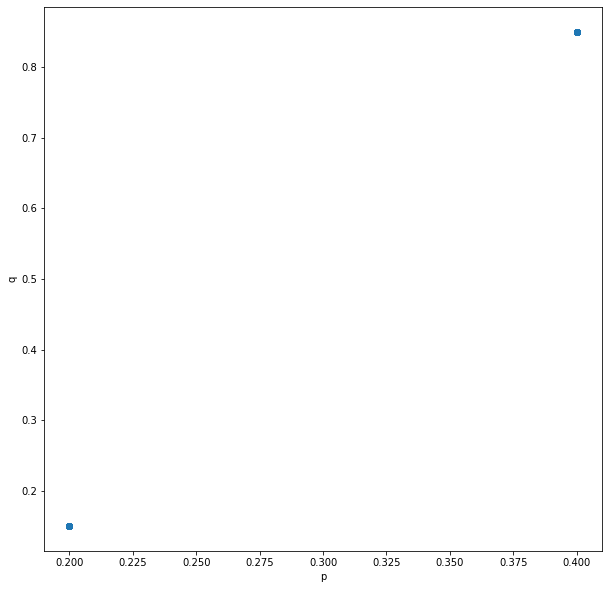

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

### Independent Scale Free

In [ ]:
NPLAYERS =  1000
NITERATIONS = 10001

game = ultimatumGame(NPLAYERS, PlayerRole.INDEPENDENT, ScaleFree=True)

#pValues
offersDicInitial = mapValuesIndex.copy()
#qValues
thresholdDicInitial = mapValuesIndex.copy()

offerDic = {}
thresholdDic = {}

#run episodes
for iteration in range(NITERATIONS):
  if iteration%(NITERATIONS//20)==0:
    print("iteration: "+str(iteration))
  offersDicInitial,offerDic,thresholdDicInitial,thresholdDic = game.runEpisode(iteration,offersDicInitial,offerDic,thresholdDicInitial,thresholdDic,stopsForGraphs, NaturalSelection=True, SocialPenalty=True)



plt.plot(bargainValues, np.array(list(offerDic[1].values()))/sum(np.array(list(offerDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(offerDic[100].values()))/sum(np.array(list(offerDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(offerDic[1000].values()))/sum(np.array(list(offerDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(offerDic[10000].values()))/sum(np.array(list(offerDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('p')
# naming the y axis
plt.ylabel('d(p)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()

plt.plot(bargainValues, np.array(list(thresholdDic[1].values()))/sum(np.array(list(thresholdDic[1].values()))) , label = "1" )
plt.plot(bargainValues, np.array(list(thresholdDic[100].values()))/sum(np.array(list(thresholdDic[100].values()))) , label = "100" )
plt.plot(bargainValues, np.array(list(thresholdDic[1000].values()))/sum(np.array(list(thresholdDic[1000].values()))) , label = "1000" )
plt.plot(bargainValues, np.array(list(thresholdDic[10000].values()))/sum(np.array(list(thresholdDic[10000].values()))) , label = "10000" )

# naming the x axis
plt.xlabel('q')
# naming the y axis
plt.ylabel('d(q)')
# show a legend on the plot
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=1)
plt.show()




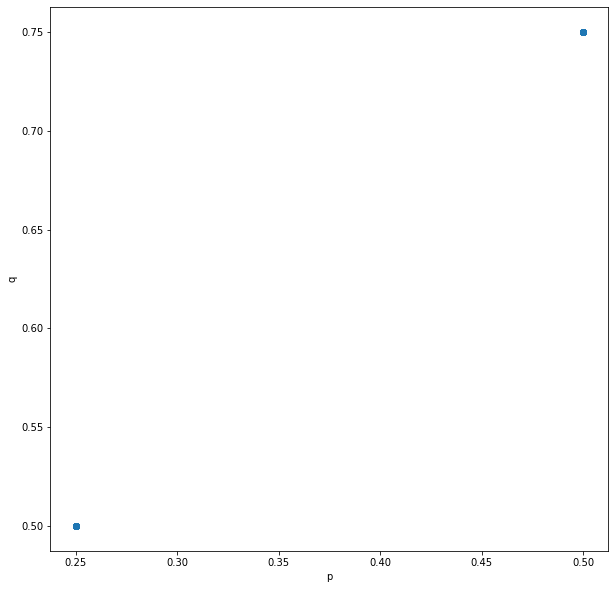

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = [game.Players[playerId].pValue for playerId in game.Players], y = [game.Players[playerId].qValue for playerId in game.Players])
plt.xlabel("p")
plt.ylabel("q")

plt.show()

#Extra

In [ ]:
degree_sequence = sorted([d for n, d in game.graph.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.plot(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()